Step 3:
Use the transformed predictors in the training set to learn either a PLS or a PCR
regression model and test the model using the test set (remember to apply the
same pre-processing you used on the training set). Determine the optimal number
of components using a 5- or 10-fold cross-validation based on the RMSE (you can
only use the training set in this phase). Report on process (show the cross-validation
profile, both in terms of the RMSE and R2 ). Report the accuracy (RMSE and R2 )
obtained on the test set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression


RED WHINE

In [2]:
df_red = pd.read_csv("../dataset/winequality-red.csv", sep=';',index_col=False)
df_red

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [3]:
df_red_1 = df_red.drop(['quality'], axis=1)
target=df_red['quality']
df_red_normalized = pd.DataFrame()
for column in df_red_1.columns:
    media = df_red_1[column].mean()
    std = df_red_1[column].std()

    df_red_normalized[column] = ((df_red_1[column]-media)/std)
matrix_red = df_red_normalized.to_numpy()
cov_red = np.cov(matrix_red,rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(cov_red)
df_eigenvalues = pd.DataFrame(eigenvalues)
df_eigenvalues = df_eigenvalues.sort_values(by=0, ascending=False)
df_eigenvectors = pd.DataFrame(eigenvectors)




In [ ]:
def k_fold(X, y, k):
    np.random.seed(42)
    
    if hasattr(X, "to_numpy"):
        X = X.to_numpy()
    if hasattr(y, "to_numpy"):
        y = y.to_numpy()

    indices = np.arange(len(X))
    np.random.shuffle(indices)

    new_X = X[indices]
    new_y = y[indices]

    fold_size = len(X) // k
    folds_X = []
    folds_y = []
    rmse_list = []
    r2_list = []
    
    for i in range(k):
        start = i * fold_size
        end = (i + 1) * fold_size
        folds_X.append(new_X[start:end])
        folds_y.append(new_y[start:end])

    for i in range(k):
        X_val = folds_X[i]
        y_val = folds_y[i]

        X_train_fold = np.vstack([folds_X[j] for j in range(k) if j != i])
        y_train_fold = np.hstack([folds_y[j] for j in range(k) if j != i])

        X_train_fold_scaled = (X_train_fold - X_train_fold.mean(axis=0)) / X_train_fold.std(axis=0)
        X_val_scaled        = (X_val - X_train_fold.mean(axis=0)) / X_train_fold.std(axis=0)

        X_train_fold_adjusted = np.hstack([np.ones((X_train_fold_scaled.shape[0], 1)), X_train_fold_scaled])

        beta_i = np.linalg.inv(X_train_fold_adjusted.T @ X_train_fold_adjusted) @ X_train_fold_adjusted.T @ y_train_fold

        X_val_adj = np.hstack([np.ones((X_val_scaled.shape[0], 1)), X_val_scaled])

        y_pred_val = X_val_adj @ beta_i
        # RMSE calculation
        rmse_fold = np.sum((y_val - y_pred_val)**2)
        rmse_fold = np.sqrt(rmse_fold/len(y_pred_val))
        # R2 calculation
        r2_fold = np.sum((y_val - y_pred_val)**2)
        r2_fold = r2_fold/np.sum((y_val - y_val.mean())**2)
        r2_fold = 1 - r2_fold

        rmse_list.append(rmse_fold)
        r2_list.append(r2_fold)
    return rmse_list, r2_list, np.mean(rmse_list), np.std(rmse_list), np.mean(r _list), np.std(r2_list)


In [5]:
def print_builtin_results(name, rmse_scores, r2_scores):
    print(f"\n====== {name} (BUILT-IN) ======")
    print(f"RMSE per fold: {['{:.4f}'.format(x) for x in rmse_scores]}")
    print(f"R² per fold  : {['{:.4f}'.format(x) for x in r2_scores]}")
    print(f"\nRMSE Mean ± Std: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
    print(f"R²   Mean ± Std: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")
    print("=========================\n")

def print_cv_results(name, results):
    print(f"\n====== {name} ======")
    print(f"RMSE per fold: {['{:.4f}'.format(x) for x in results[0]]}")
    print(f"R² per fold  : {['{:.4f}'.format(x) for x in results[1]]}")
    print(f"\nRMSE Mean ± Std: {results[2]:.4f} ± {results[3]:.4f}")
    print(f"R²   Mean ± Std: {results[4]:.4f} ± {results[5]:.4f}")
    print("=========================\n")

#PCR

In [19]:
columns=['PC1']
RMSE_per_component_5fold = []
RMSE_per_component_10fold=[]
R2_per_component_5fold = []
R2_per_component_10fold=[]
for i in range(2,12):
    df_eigenvectors = pd.DataFrame(eigenvectors)
    nomes_colunas = df_red_1.columns.tolist()
    df_eigenvectors.columns = nomes_colunas
    df_eigenvectors = df_eigenvectors[0:i]
    column='PC'+str(i)
    columns.append(column)
    V = df_eigenvectors.T.to_numpy()
    pca_score = df_red_normalized.to_numpy().dot(V) 
    df_pcs = pd.DataFrame(pca_score,columns=columns)
    X_train,X_text,y_train,y_test=train_test_split(df_pcs,target,test_size=0.2,random_state=42)
    k_fold_results_5 = k_fold(X_train, y_train.to_numpy(), k=5)
    k_fold_results_10 = k_fold(X_train, y_train.to_numpy(), k=10)
    print("\nNumber of Principal Components:", i)
    print_cv_results("5-FOLD CROSS VALIDATION", k_fold_results_5)
    print_cv_results("10-FOLD CROSS VALIDATION", k_fold_results_10)
    RMSE_per_component_5fold.append(k_fold_results_5[2])
    R2_per_component_5fold.append(k_fold_results_5[4])
    RMSE_per_component_10fold.append(k_fold_results_10[2])
    R2_per_component_10fold.append(k_fold_results_10[4])





Number of Principal Components: 2

====== 5-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.7461', '0.7743', '0.8092', '0.8290', '0.7797']
R² per fold  : ['0.0352', '0.0594', '0.0417', '-0.0034', '0.0577']

RMSE Mean ± Std: 0.7877 ± 0.0288
R²   Mean ± Std: 0.0381 ± 0.0227


====== 10-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.7512', '0.7418', '0.8250', '0.7175', '0.8330', '0.7865', '0.8557', '0.8002', '0.7975', '0.7579']
R² per fold  : ['0.0408', '0.0259', '0.0537', '0.0718', '0.0118', '0.0746', '-0.0516', '0.0556', '0.0655', '0.0374']

RMSE Mean ± Std: 0.7866 ± 0.0419
R²   Mean ± Std: 0.0386 ± 0.0356


Number of Principal Components: 3

====== 5-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.7481', '0.7730', '0.8110', '0.8223', '0.7716']
R² per fold  : ['0.0300', '0.0625', '0.0376', '0.0129', '0.0773']

RMSE Mean ± Std: 0.7852 ± 0.0274
R²   Mean ± Std: 0.0441 ± 0.0230


====== 10-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.7484', '0.7482', '0.8129', '0.7328', '0.8305', '0.7

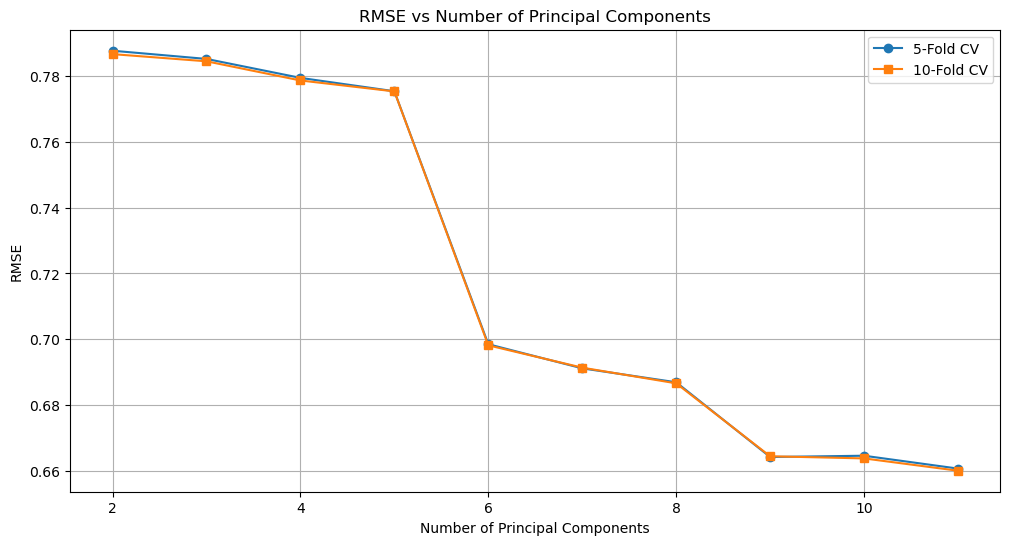

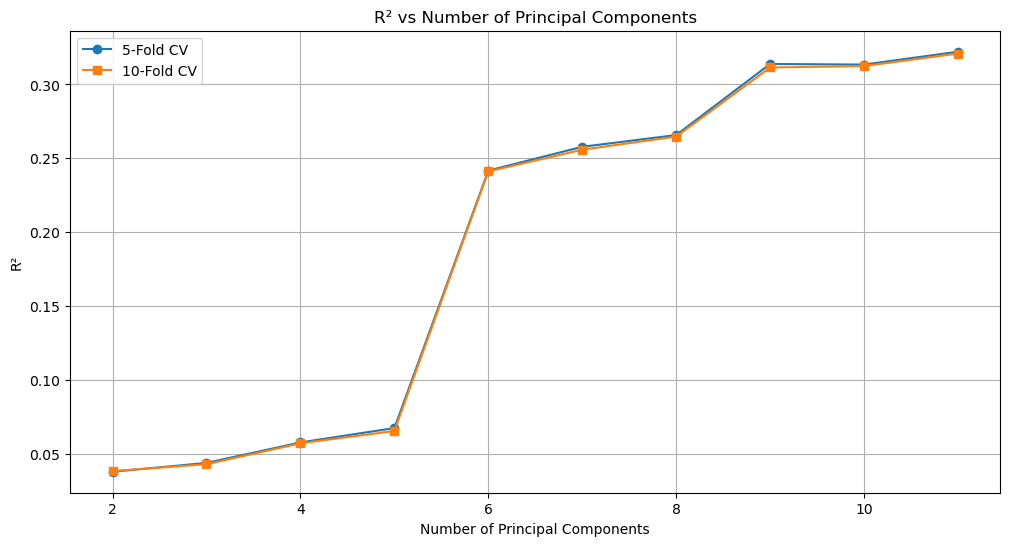

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(range(2, 12), RMSE_per_component_5fold, marker='o', label='5-Fold CV')
plt.plot(range(2, 12), RMSE_per_component_10fold, marker='s', label='10-Fold CV')
plt.title('RMSE vs Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()  

plt.figure(figsize=(12, 6))
plt.plot(range(2, 12), R2_per_component_5fold, marker='o', label='5-Fold CV')
plt.plot(range(2, 12), R2_per_component_10fold, marker='s', label='10-Fold CV')
plt.title('R² vs Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('R²')
plt.legend()
plt.grid()
plt.show()

WHITE WINE

In [21]:
df_white = pd.read_csv("../dataset/winequality-white.csv", sep=';',index_col=False)
df_white

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [23]:
df_white_1 = df_white.drop(['quality'], axis=1)
target=df_white['quality']
df_white_normalized = pd.DataFrame()
for column in df_white_1.columns:
    media = df_white_1[column].mean()
    std = df_white_1[column].std()

    df_white_normalized[column] = ((df_white_1[column]-media)/std)
matrix_white = df_white_normalized.to_numpy()
cov_white = np.cov(matrix_white,rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(cov_white)
df_eigenvalues = pd.DataFrame(eigenvalues)
df_eigenvalues = df_eigenvalues.sort_values(by=0, ascending=False)
df_eigenvectors = pd.DataFrame(eigenvectors)

In [27]:
columns=['PC1']
RMSE_per_component_5fold = []
RMSE_per_component_10fold=[]
R2_per_component_5fold = []
R2_per_component_10fold=[]
for i in range(2,12):
    df_eigenvectors = pd.DataFrame(eigenvectors)
    nomes_colunas = df_white_1.columns.tolist()
    df_eigenvectors.columns = nomes_colunas
    df_eigenvectors = df_eigenvectors[0:i]
    column='PC'+str(i)
    columns.append(column)
    V = df_eigenvectors.T.to_numpy()
    pca_score = df_white_normalized.to_numpy().dot(V) 
    df_pcs = pd.DataFrame(pca_score,columns=columns)
    X_train,X_text,y_train,y_test=train_test_split(df_pcs,target,test_size=0.2,random_state=42)
    k_fold_results_5 = k_fold(X_train, y_train.to_numpy(), k=5)
    k_fold_results_10 = k_fold(X_train, y_train.to_numpy(), k=10)
    print("\nNumber of Principal Components:", i)
    print_cv_results("5-FOLD CROSS VALIDATION", k_fold_results_5)
    print_cv_results("10-FOLD CROSS VALIDATION", k_fold_results_10)
    RMSE_per_component_5fold.append(k_fold_results_5[2])
    R2_per_component_5fold.append(k_fold_results_5[4])
    RMSE_per_component_10fold.append(k_fold_results_10[2])
    R2_per_component_10fold.append(k_fold_results_10[4])



Number of Principal Components: 2

====== 5-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.8721', '0.8605', '0.8658', '0.9034', '0.9039']
R² per fold  : ['0.0178', '-0.0017', '0.0136', '0.0138', '0.0094']

RMSE Mean ± Std: 0.8811 ± 0.0188
R²   Mean ± Std: 0.0106 ± 0.0067


====== 10-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.8473', '0.8953', '0.8440', '0.8746', '0.8521', '0.8831', '0.8728', '0.9328', '0.9008', '0.9072']
R² per fold  : ['0.0277', '0.0090', '-0.0118', '0.0118', '0.0039', '0.0225', '0.0208', '0.0038', '0.0031', '0.0119']

RMSE Mean ± Std: 0.8810 ± 0.0272
R²   Mean ± Std: 0.0103 ± 0.0109


Number of Principal Components: 3

====== 5-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.8771', '0.8554', '0.8595', '0.8991', '0.8941']
R² per fold  : ['0.0064', '0.0101', '0.0277', '0.0232', '0.0309']

RMSE Mean ± Std: 0.8770 ± 0.0176
R²   Mean ± Std: 0.0197 ± 0.0097


====== 10-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.8584', '0.8928', '0.8423', '0.8662', '0.8416', '0.8

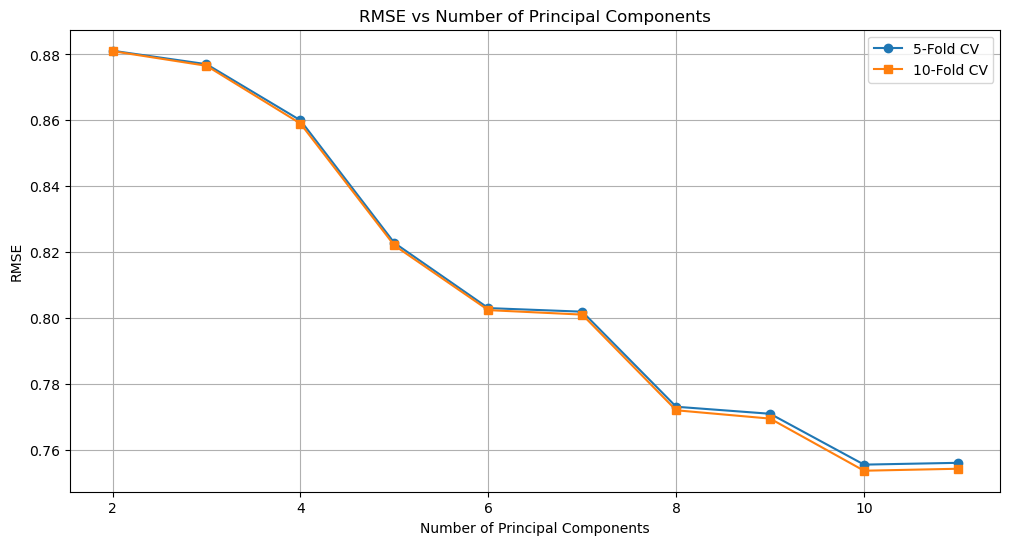

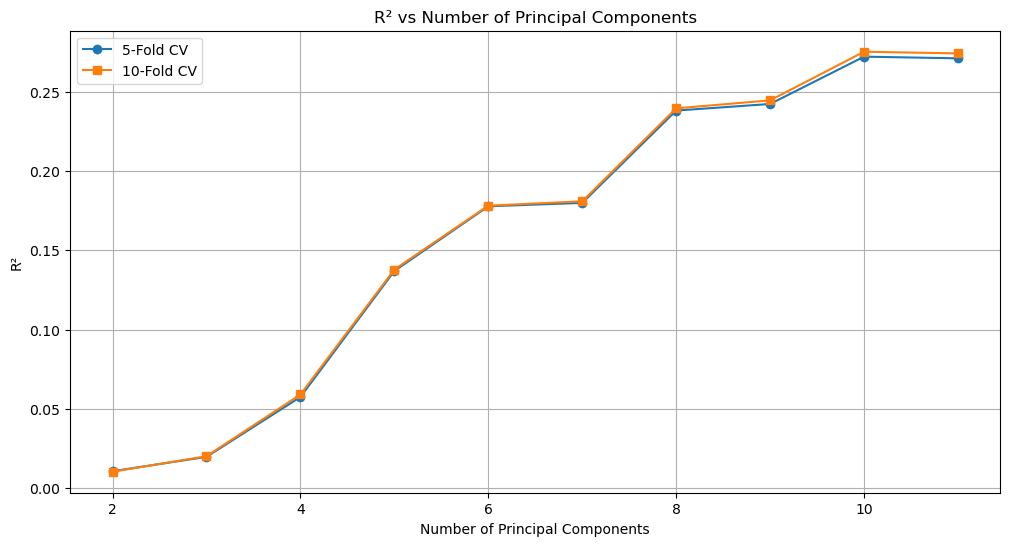

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(range(2, 12), RMSE_per_component_5fold, marker='o', label='5-Fold CV')
plt.plot(range(2, 12), RMSE_per_component_10fold, marker='s', label='10-Fold CV')
plt.title('RMSE vs Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()  

plt.figure(figsize=(12, 6))
plt.plot(range(2, 12), R2_per_component_5fold, marker='o', label='5-Fold CV')
plt.plot(range(2, 12), R2_per_component_10fold, marker='s', label='10-Fold CV')
plt.title('R² vs Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('R²')
plt.legend()
plt.grid()
plt.show()